## Preliminaries

In [1]:
!nvidia-smi

Mon Dec 18 16:09:29 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A4000                On | 00000000:02:00.0 Off |                  Off |
| 41%   42C    P8               14W / 140W|     30MiB / 16376MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%%capture
!pip install torchmetrics
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install einops
!pip install torchinfo

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from torchvision.transforms.functional import rotate
import pandas as pd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset
import torch.nn.functional as F
import numpy as np
from einops.layers.torch import Rearrange
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

torch.manual_seed(0xC0FFEE)

/home/ubuntu/miniconda3/envs/nickl_ViT_quant/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Dataset (CIFAR10)

In [4]:
data_root = './data/cifar10'

In [5]:
train_data = torchvision.datasets.CIFAR10(root=data_root,
                                             train=True,
                                             download=False,
                                             transform=transforms.ToTensor())

In [6]:
loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=False, num_workers=1)

In [7]:
mean = 0.
std = 0.
nb_samples = 0.
for data, _ in loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

In [8]:
print(mean)
print(std)

tensor([0.4914, 0.4822, 0.4465])
tensor([0.2023, 0.1994, 0.2010])


## Define Data Transforms & Augmentations

In [10]:
train_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize(mean, std),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(degrees=45, translate=(0.3, 0.3)),
                                      ])

test_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((224, 224)),
                                     transforms.Normalize(mean, std)])

## Create Train, Val and Test Dataloaders

In [11]:
train_data = torchvision.datasets.CIFAR10(root=data_root,
                                          train=True,
                                          download=False,
                                          transform=train_transform)

test_data = torchvision.datasets.CIFAR10(root=data_root,
                                         train=False,
                                         download=False,
                                         transform=test_transform)

classes = train_data.classes

print(f'Train: {len(train_data)}, Test: {len(test_data)}')

Train: 50000, Test: 10000


In [12]:
batch_size = 16

train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               num_workers=1,
                                               pin_memory=True)

test_dataloader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=1)

## Display Sample Images

In [13]:
def show_img(img):
    img = (mean.view(-1,1,1) + img * std.view(-1,1,1))
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))

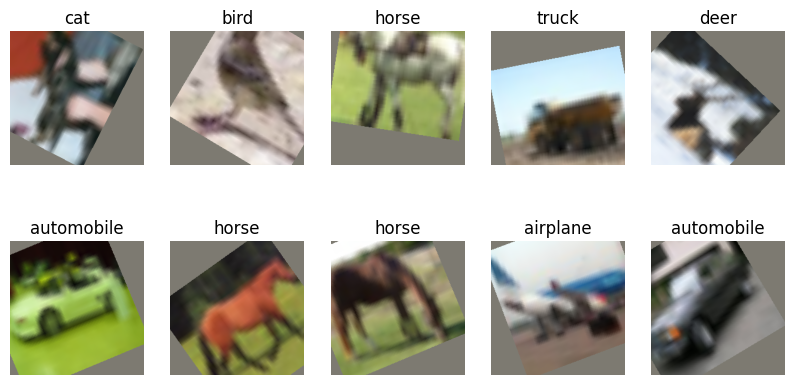

In [14]:
images, labels = next(iter(train_dataloader))
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    show_img(images[i])
    plt.title(f'{classes[labels[i]]}')
    plt.axis('off')

# Pretrained Model

In [15]:
class PretrainedVit(nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        self.vit = models.vit_b_32(weights  = models.ViT_B_32_Weights)
        self.freeze_weights()
        self.vit.heads = nn.Linear(self.vit.hidden_dim, num_classes)
    
    def freeze_weights(self):
        for p in self.vit.parameters():
            p = p.requires_grad_(False)
            
    def forward(self, x):
        return self.vit(x)

# Custom Model

In [16]:
class MHA(nn.Module):
    
    def __init__(self, d_model, n_heads, dropout):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads
        
        self.Q = nn.Linear(d_model, d_model)
        self.K = nn.Linear(d_model, d_model)
        self.V = nn.Linear(d_model, d_model)

        self.Out = nn.Linear(d_model , d_model)
        
        self.scale = self.d_head ** -0.5
        self.drop = nn.Dropout(dropout)
        
    def forward(self, x):
        B, S, C = x.shape
        q = self.Q(x).view(B, S, self.n_heads, self.d_head).transpose(1,2)
        k = self.K(x).view(B, S, self.n_heads, self.d_head).transpose(1,2)
        v = self.V(x).view(B, S, self.n_heads, self.d_head).transpose(1,2)
        
        qk = (q @ k.transpose(-2, -1)) * self.scale
        
        att = F.softmax(qk, dim=-1)
        self.att_weights = att
        
        att_v = att @ v
        
        out = self.drop(self.Out(att_v.transpose(1,2).contiguous().view(B, S, C)))
        
        return out, att

In [17]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, num_heads, mul = 4 ,dropout = 0.1):

        super().__init__()

        self.sa = MHA(d_model, num_heads, dropout)

        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * mul),
            nn.GELU(),
            nn.Linear(mul * d_model, d_model)
        )

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x, att = self.sa(x)
        self.att = att
        x = x + self.ln1(x)
        x = x + self.ln2(self.ffn(x))

        return x

In [18]:
class ViTEncoder(nn.Module):

    def __init__(self, in_ch, d_model, num_heads, n_blocks, num_classes = 100, mul = 4, patch_size = 16, img_size = 224):

        
        super().__init__()

        
        self.lp_src = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.LayerNorm(patch_size**2 * in_ch),
            nn.Linear(patch_size**2* in_ch, d_model),
            nn.LayerNorm(d_model),
        ) 

        self.cls = nn.Parameter(torch.randn(1,1,d_model))
        
        self.to_cls_token = nn.Identity()
        self.pos = nn.Parameter(torch.randn(1, (img_size // patch_size)**2 + 1, d_model))


        self.blocks = nn.Sequential(
            *[EncoderLayer(d_model, num_heads, mul) for _ in range(n_blocks)]
        )

        self.cl = nn.Linear(d_model, num_classes)

    def forward(self, x):
        cls_token = self.cls.expand(x.shape[0], -1, -1)
        x = self.lp_src(x)

        x = torch.cat([cls_token, x], dim = 1) + self.pos

        for block in self.blocks:

            x = block(x)
        
        x = self.to_cls_token(x[:,0])
        x = self.cl(x)
        
        return x

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = PretrainedVit(num_classes=len(classes)).to(device)
print('Number of weights:', np.sum([np.prod(p.shape) for p in model.parameters()]))

Number of weights: 87462922


In [20]:
custom_model = ViTEncoder(3, 512, 8, 10, len(classes), 4, 16, 224).to(device)
print('Number of weights:', np.sum([np.prod(p.shape) for p in custom_model.parameters()]))

Number of weights: 32026634


# Train, test procedure

In [21]:
def epoch_train(loader, clf, criterion, opt, device):
    clf.train(True)
    running_loss, running_acc = 0, 0

    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        y_pred = clf(images)
        loss = criterion(y_pred, labels)

        opt.zero_grad()
        loss.backward()
        opt.step()

        running_loss += loss.item()
        running_acc += (y_pred.argmax(dim = 1) == labels).sum()

    epoch_train_loss = running_loss / len(loader)
    epoch_train_acc = running_acc / len(loader.dataset)

    return epoch_train_loss, epoch_train_acc


def epoch_test(loader, clf, criterion, device):
    clf.eval()
    running_loss, running_acc = 0, 0

    for images, labels in tqdm(loader): 
        images = images.to(device)
        labels = labels.to(device)

        y_pred = clf(images)
        loss = criterion(y_pred, labels)

        running_loss += loss.item()
        running_acc += (y_pred.argmax(dim = 1) == labels).sum()

    epoch_test_loss = running_loss / len(loader)
    epoch_test_acc = running_acc / len(loader.dataset)

    return epoch_test_loss, epoch_test_acc


def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50, device='cpu'):
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt, device)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion, device)

        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

In [22]:
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)
criterion = nn.CrossEntropyLoss()

In [29]:
train(train_dataloader, test_dataloader, model, criterion, opt, 10, device)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [04:43<42:33, 283.74s/it]

[Epoch 1] train loss: 2.555; train acc: 0.45; test loss: 1.333; test acc: 0.67


 20%|██        | 2/10 [09:11<36:32, 274.10s/it]

[Epoch 2] train loss: 1.535; train acc: 0.61; test loss: 1.049; test acc: 0.71


 30%|███       | 3/10 [13:39<31:40, 271.48s/it]

[Epoch 3] train loss: 1.345; train acc: 0.64; test loss: 0.951; test acc: 0.74


 40%|████      | 4/10 [18:06<26:59, 269.92s/it]

[Epoch 4] train loss: 1.251; train acc: 0.66; test loss: 0.899; test acc: 0.74


 50%|█████     | 5/10 [22:36<22:28, 269.67s/it]

[Epoch 5] train loss: 1.187; train acc: 0.67; test loss: 0.871; test acc: 0.75


 60%|██████    | 6/10 [27:03<17:55, 268.82s/it]

[Epoch 6] train loss: 1.145; train acc: 0.68; test loss: 0.849; test acc: 0.75


 70%|███████   | 7/10 [31:31<13:26, 268.74s/it]

[Epoch 7] train loss: 1.106; train acc: 0.69; test loss: 0.833; test acc: 0.76


 80%|████████  | 8/10 [36:02<08:58, 269.35s/it]

[Epoch 8] train loss: 1.071; train acc: 0.70; test loss: 0.816; test acc: 0.76


 90%|█████████ | 9/10 [40:29<04:28, 268.58s/it]

[Epoch 9] train loss: 1.050; train acc: 0.70; test loss: 0.807; test acc: 0.76


100%|██████████| 10/10 [44:57<00:00, 269.75s/it]

[Epoch 10] train loss: 1.034; train acc: 0.71; test loss: 0.807; test acc: 0.76


In [40]:
# torch.save(model.state_dict(), 'model_state.pth')

# Visualize results

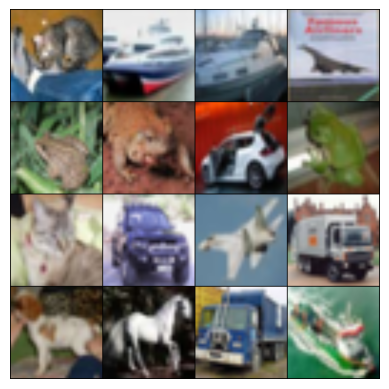

In [28]:
images, labels = next(iter(test_dataloader))
images_np = torchvision.utils.make_grid(mean.view(-1,1,1) + images * std.view(-1,1,1), nrow=4).cpu().numpy().transpose((1, 2, 0))
plt.imshow(images_np)
plt.axis('off')
plt.show()

In [145]:
model = ViTEncoder(3, 512, 8, 10, len(classes), 4, 16, 224).to(device)
model.load_state_dict(torch.load('./models/vit_cifar10_v3.pt', map_location = torch.device(device)))

<All keys matched successfully>

In [146]:
model.eval()
output = model(images.to(device))
pred = torch.argmax(output, dim = 1)

Original label: ship


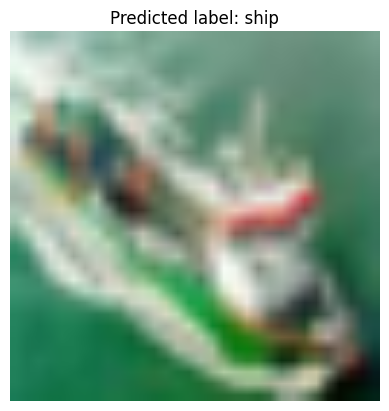

In [148]:
i = 15
img_np = (mean.view(-1,1,1) + images * std.view(-1,1,1))[i].cpu().numpy().transpose((1, 2, 0))

plt.imshow(img_np)
print(f'Original label: {classes[labels[i]]}')
plt.title(f'Predicted label: {classes[pred[i]]}')
plt.axis('off')  
plt.show()

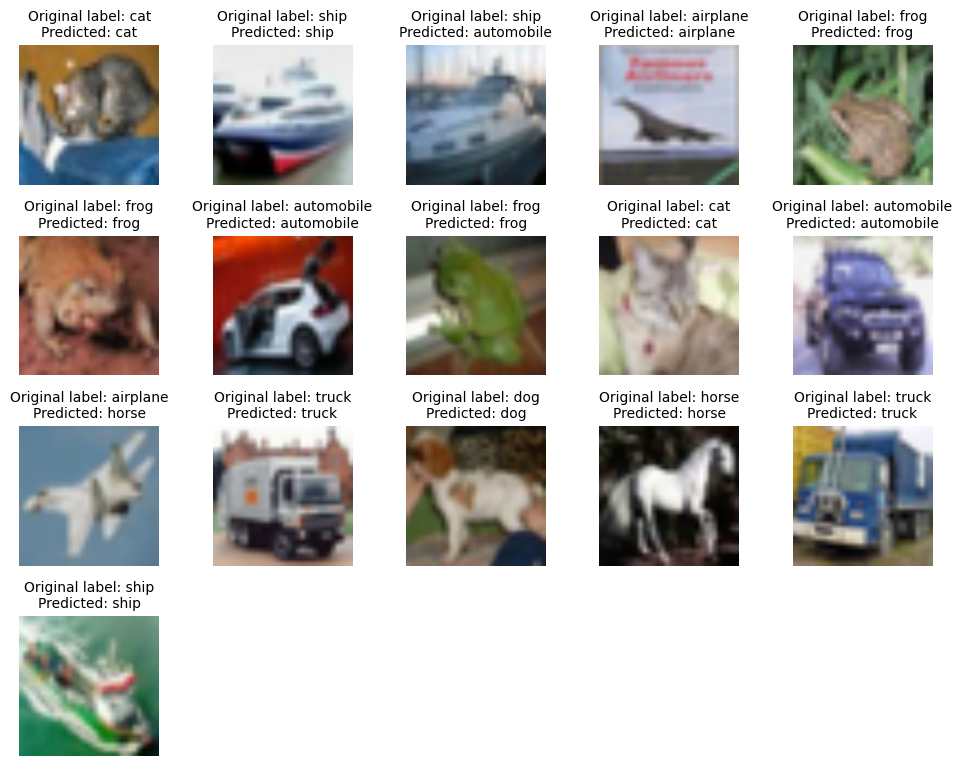

In [149]:
plt.figure(figsize=(10,8))
for i in range(16):
    plt.subplot(4, 5, i+1)
    plt.imshow((mean.view(-1,1,1) + images * std.view(-1,1,1))[i].cpu().numpy().transpose((1, 2, 0)))
    plt.title(f'Original label: {classes[labels[i]]}\nPredicted: {classes[pred[i]]}', fontsize=10)
    plt.tight_layout()    
    plt.axis('off')

# Parameters for model optimization quality (for original model)

## Latency

In [150]:
num_warmup_runs = 10
for _ in range(num_warmup_runs):
    with torch.no_grad():
        _ = model(images.to(device))

In [151]:
import time

num_runs = 10  
latencies = []

with torch.no_grad():
    for _ in range(num_runs):
        start_time = time.time()
        _ = model(images.to(device))
        latency = time.time() - start_time
        latencies.append(latency)

average_latency = sum(latencies) / num_runs
print(f'Average Latency: {average_latency} seconds')

Average Latency: 0.030525922775268555 seconds


## Model size

In [152]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('Model size: {:.3f}MB'.format(size_all_mb))

model size: 122.172MB


# Model optimization

## Quantization

### Dynamic Quantization

In [21]:
import torch.quantization
import os

In [22]:
original_model = ViTEncoder(3, 512, 8, 10, len(classes), 4, 16, 224)
original_model.load_state_dict(torch.load('./models/vit_cifar10_v3.pt', map_location = torch.device('cpu')))
quantized_model = torch.quantization.quantize_dynamic(original_model, {nn.Linear}, dtype=torch.qint8)

### Post-Training Static Quantization

In [23]:
original_model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare(original_model, inplace=True)
stat_quantized_model = torch.quantization.convert(original_model, inplace=False)

### Quantization Aware Training

In [24]:
original_model.train()
original_model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(original_model, inplace=True)
QAT_quantized_model = torch.quantization.convert(original_model, inplace=False)

In [206]:
torch.save(quantized_model.state_dict(), 'dyn_quant_model_state.pth')
torch.save(stat_quantized_model.state_dict(), 'static_quant_model_state.pth')
torch.save(QAT_quantized_model.state_dict(), 'QAT_quant_model_state.pth')

## Models size comparison

In [30]:
def print_size_of_model(model, label=''):
    torch.save(model.state_dict(), 'temp.p')
    size=os.path.getsize('temp.p')
    print('Model: ', label, ' \t','Size (KB):', size / 1e3)
    os.remove('temp.p')
    return size

In [26]:
f = print_size_of_model(original_model, 'fp32')
q = print_size_of_model(quantized_model, 'int8')
print('Dynamic quantized model is {0:.2f} times smaller than original'.format(f / q))

Model:  fp32  	 Size (KB): 128994.146


Model:  int8  	 Size (KB): 32626.984
Dynamic quantized model is 3.95 times smaller than original


## Models latency comparison

In [27]:
input_size = (3, 224, 224) 
inputs = torch.randn(32, *input_size)

print('Floating point FP32: ')
%timeit original_model(inputs)

print('\nQuantized INT8: ')
%timeit quantized_model(inputs)

Floating point FP32: 


3.76 s ± 140 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Quantized INT8: 
1.95 s ± 64.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Models tensors mean absolute error comparison

In [211]:
out1 = original_model(inputs)
mag1 = torch.mean(abs(out1)).item()
print('Mean absolute value of output tensor values in the FP32 model is {0:.5f} '.format(mag1))

out2 = quantized_model(inputs)
mag2 = torch.mean(abs(out2)).item()
print('Mean absolute value of output tensor values in the INT8 model is {0:.5f}'.format(mag2))

mag3 = torch.mean(abs(out1 - out2)).item()
print('Mean absolute value of the difference between the output tensors is {0:.5f} or {1:.2f} percent'.format(mag3, mag3 / mag1 * 100))

Mean absolute value of output tensor values in the FP32 model is 2.81729 
Mean absolute value of output tensor values in the INT8 model is 3.06525
Mean absolute value of the difference between the output tensors is 0.43267 or 15.36 percent


## Models number of parameters comparison

In [213]:
print('Original model')
print(f'Number of weights:', np.sum([np.prod(p.shape) for p in model.parameters()]))

print('\nQuantized model')
print('Number of weights:', np.sum([np.prod(p.shape) for p in quantized_model.parameters()]))

Original model
Number of weights: 32026634

Quantized model
Number of weights: 124416


## Models comparison

In [181]:
original_model = ViTEncoder(3, 512, 8, 10, len(classes), 4, 16, 224).to(device)
original_model.load_state_dict(torch.load('./models/vit_cifar10_v3.pt', map_location = torch.device(device)))
quantized_model = torch.quantization.quantize_dynamic(original_model, {nn.Linear}, dtype=torch.qint8)

original_model.eval()
quantized_model.eval()

ViTEncoder(
  (lp_src): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
    (1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (2): DynamicQuantizedLinear(in_features=768, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (to_cls_token): Identity()
  (blocks): Sequential(
    (0): EncoderLayer(
      (sa): MHA(
        (Q): DynamicQuantizedLinear(in_features=512, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
        (K): DynamicQuantizedLinear(in_features=512, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
        (V): DynamicQuantizedLinear(in_features=512, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
        (Out): DynamicQuantizedLinear(in_features=512, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
        (drop): Dropout(p=0.1, inplace=False)
      )

In [170]:
output_orig = original_model(images.to(device))
pred_orig = torch.argmax(output_orig, dim = 1)

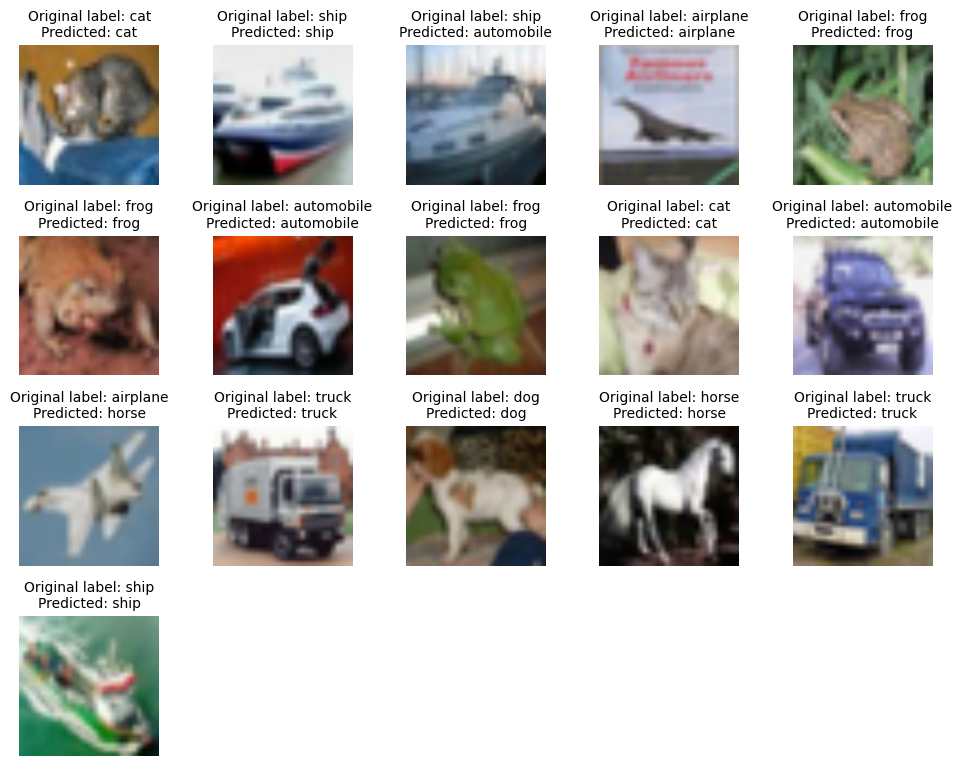

In [172]:
plt.figure(figsize=(10,8))
for i in range(16):
    plt.subplot(4, 5, i+1)
    plt.imshow((mean.view(-1,1,1) + images * std.view(-1,1,1))[i].cpu().numpy().transpose((1, 2, 0)))
    plt.title(f'Original label: {classes[labels[i]]}\nPredicted: {classes[pred_orig[i]]}', fontsize=10)
    plt.tight_layout()    
    plt.axis('off')

In [183]:
test_loss, test_acc = epoch_test(test_dataloader, original_model, criterion, device)
print(f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

100%|██████████| 625/625 [00:23<00:00, 26.25it/s]

test loss: 1.413; test acc: 0.62


In [184]:
original_model = ViTEncoder(3, 512, 8, 10, len(classes), 4, 16, 224)
original_model.load_state_dict(torch.load('./models/vit_cifar10_v3.pt', map_location = torch.device(device)))
quantized_model = torch.quantization.quantize_dynamic(original_model, {nn.Linear}, dtype=torch.qint8)

original_model.eval()
quantized_model.eval()

ViTEncoder(
  (lp_src): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
    (1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (2): DynamicQuantizedLinear(in_features=768, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
    (3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (to_cls_token): Identity()
  (blocks): Sequential(
    (0): EncoderLayer(
      (sa): MHA(
        (Q): DynamicQuantizedLinear(in_features=512, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
        (K): DynamicQuantizedLinear(in_features=512, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
        (V): DynamicQuantizedLinear(in_features=512, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
        (Out): DynamicQuantizedLinear(in_features=512, out_features=512, dtype=torch.qint8, qscheme=torch.per_tensor_affine)
        (drop): Dropout(p=0.1, inplace=False)
      )

In [176]:
output_qua = quantized_model(images)
pred_qua = torch.argmax(output_qua, dim = 1)

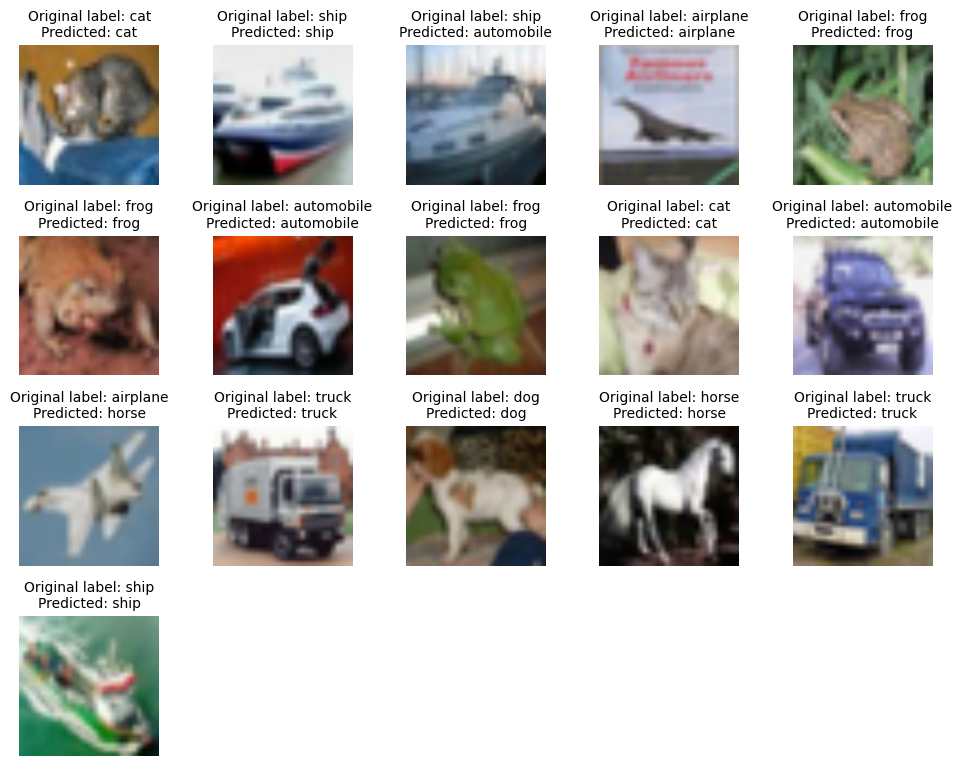

In [177]:
plt.figure(figsize=(10,8))
for i in range(16):
    plt.subplot(4, 5, i+1)
    plt.imshow((mean.view(-1,1,1) + images * std.view(-1,1,1))[i].cpu().numpy().transpose((1, 2, 0)))
    plt.title(f'Original label: {classes[labels[i]]}\nPredicted: {classes[pred_qua[i]]}', fontsize=10)
    plt.tight_layout()    
    plt.axis('off')

In [187]:
test_loss, test_acc = epoch_test(test_dataloader, quantized_model, criterion, 'cpu')
print(f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

100%|██████████| 625/625 [10:45<00:00,  1.03s/it]

test loss: 1.415; test acc: 0.62


## Quantization Basics 

(Reference to [Lei Mao](https://leimao.github.io/article/Neural-Networks-Quantization/) and [PyTorch quantization](https://pytorch.org/docs/stable/quantization.html#general-quantization-flow))

Quantization maps a floating-point value $x \in [\alpha, \beta]$ to a $b$-bit integer $x_q \in [\alpha_q, \beta_q]$.

The de-quantization process is defined as $x = s(x_q + z)$, and the quantization process is defined as $x_q = \text{round}\left(\frac{1}{s}x - z\right)$, where $c$ and $d$ are variables.

To derive $s$ and $z$, we solve the linear system:
$$
\begin{align*}
\beta &= c(\beta_q + d) \\
\alpha &= c(\alpha_q + d)
\end{align*}
$$

The solutions are:
$$
\begin{align*}
c &= \frac{\beta - \alpha}{\beta_q - \alpha_q} \\
d &= \frac{\alpha\beta_q - \beta\alpha_q}{\beta - \alpha}
\end{align*}
$$

To ensure that $0$ in floating point is represented exactly after quantization:
$$
\begin{align*}
d = \text{round}\left(\frac{\alpha\beta_q - \beta\alpha_q}{\beta - \alpha}\right)
\end{align*}
$$

By convention, we denote $c$ as the scale $s$ and $-d$ as the zero point $z$.

In summary, the de-quantization process is:
$$
\begin{align*}
x = s(x_q - z)
\end{align*}
$$


and the quantization process is:
$$
\begin{align*}
x_q = \text{round}\left(\frac{1}{s}x + z\right)
\end{align*}
$$

The values of scale $s$ and zero point $z$ are:
$$
\begin{align*}
s &= \frac{\beta - \alpha}{\beta_q - \alpha_q} \\
z &= \text{round}\left(\frac{\beta\alpha_q - \alpha\beta_q}{\beta - \alpha}\right)
\end{align*}
$$

## Value Clipping

In practice, the quantization process may produce $x$ outside the range $[\alpha, \beta]$, so we introduce a clip step:
$$
\begin{align*}
x_q = \text{clip}\left(\text{round}\left(\frac{1}{s}x + z\right), \alpha_q, \beta_q\right)\end{align*}
$$

where $\text{clip}(x, l, u)$ is defined as:
$$
\begin{align*}
\text{clip}(x, l, u) = \begin{cases} l & \text{if } x < l \\ x & \text{if } l \leq x \leq u \\ u & \text{if } x > u \end{cases}
\end{align*}
$$

## Scale Quantization Mapping

For signed INTb, where $(\alpha_q, \beta_q) = (-2^{b-1}+1, 2^{b-1}-1)$, and if we force $z = 0$, we get:
$$
\begin{align*}
\alpha_q = -\beta_q \text{ round}\left(\frac{\beta\alpha_q - \alpha\beta_q}{\beta - \alpha}\right) = 0
\end{align*}
$$

This results in $\alpha = -\beta$, mapping the floating-point range $[\alpha, -\alpha]$ to the integer range $[\alpha_q, -\alpha_q]$. This is known as symmetric quantization mapping.


## Quantized Matrix Multiplication

Suppose we perform the matrix multiplication $Y = XW + b$, where $X \in \mathbb{R}^{m \times p}$, $W \in \mathbb{R}^{p \times n}$, and $b \in \mathbb{R}^n$ resulting in $Y \in \mathbb{R}^{m \times n}$.

$$
\begin{align*}
Y_{i,j} = b_j + \sum_{k=1}^{p} X_{i,k}W_{k,j}
\end{align*}
$$

To use quantized values, apply the de-quantization equation:

$$
\begin{align*}
Y_{i,j} &= s_b (b_{q,j} - z_b) + \sum_{k=1}^{p} s_X(X_{q,i,k} - z_X) s_W(W_{q,k,j} - z_W) = \\
&= s_b (b_{q,j} - zb) + s_Xs_W \left[\left(\sum_{k=1}^{p} X_{q,i,k}W_{q,k,j}\right) - \left(z_W \sum_{k=1}^{p} X_{q,i,k}\right) - \left(zX \sum_{k=1}^{p} W_{q,k,j}\right) + pz_Xz_W\right] = \\
&= s_Y (Y_{q,i,j} - z_Y)
\end{align*}
$$

where $X_q$, $W_q$, $b_q$, and $Y_q$ are the quantized matrices for $X$, $W$, $b$, and $Y$ respectively. $s_X$, $s_W$, $sb$, and $sY$ are the scales for $X$, $W$, $b$, and $Y$ respectively. $z_X$, $z_W$, $z_b$, and $z_Y$ are the zero points for $X$, $W$, $b$, and $Y$ respectively.

Therefore,
$$
\begin{align*}
Y_{q,i,j} = zY + sbsY(b_{q,j} - z_b) + s_Xs_W s_Y \left[\left(\sum_{k=1}^{p} X_{q,i,k}W_{q,k,j}\right) - \left(z_W \sum_{k=1}^{p} X_{q,i,k}\right) - \left(z_X \sum_{k=1}^{p} W_{q,k,j}\right) + pz_Xz_W\right]
\end{align*}
$$

$zY$, $\frac{s_b}{s_Y}(b_{q,j} - z_b)$, $z_X \sum_{k=1}^{p} W_{q,k,j}$, $pz_Xz_W$ are constants during inference and can be computed offline before inference.

In [23]:
import numpy as np

def quantization(x, s, z, alpha_q, beta_q):
    x_q = np.round(1 / s * x + z, 0)
    x_q = np.clip(x_q, a_min=alpha_q, a_max=beta_q)

    return x_q


def quantization_int8(x, s, z):
    x_q = quantization(x, s, z, alpha_q=-128, beta_q=127)
    x_q = x_q.astype(np.int8)

    return x_q


def dequantization(x_q, s, z):
    x_q = x_q.astype(np.int32)
    x = s * (x_q - z)
    x = x.astype(np.float32)

    return x


def generate_quantization_constants(alpha, beta, alpha_q, beta_q):
    s = (beta - alpha) / (beta_q - alpha_q)
    z = int((beta * alpha_q - alpha * beta_q) / (beta - alpha))

    return s, z


def generate_quantization_int8_constants(alpha, beta):
    b = 8
    alpha_q = -2**(b - 1)
    beta_q = 2**(b - 1) - 1

    s, z = generate_quantization_constants(alpha=alpha,
                                           beta=beta,
                                           alpha_q=alpha_q,
                                           beta_q=beta_q)

    return s, z


def quantization_matrix_multiplication_int8(X_q, W_q, b_q, s_X, z_X, s_W, z_W,
                                            s_b, z_b, s_Y, z_Y):
    p = W_q.shape[0]

    Y_q_simulated = (z_Y + (s_b / s_Y * (b_q.astype(np.int32) - z_b)) + 
                     ((s_X * s_W / s_Y) * (np.matmul(X_q.astype(np.int32), W_q.astype(np.int32)) -
                                           z_W * np.sum(X_q.astype(np.int32), axis=1, keepdims=True) - 
                                           z_X * np.sum(W_q.astype(np.int32), axis=0, keepdims=True) + p * z_X * z_W)))

    Y_q_simulated = np.round(Y_q_simulated, 0)
    Y_q_simulated = np.clip(Y_q_simulated, a_min=-128, a_max=127)
    Y_q_simulated = Y_q_simulated.astype(np.int8)

    return Y_q_simulated

In [24]:
np.random.seed(0xC0FFEE)

m = 2
p = 3
n = 4

# X
alpha_X = np.random.randint(-100, 80)
beta_X = np.random.randint(-100, 80)
s_X, z_X = generate_quantization_int8_constants(alpha=alpha_X, beta=beta_X)
X = np.random.uniform(low=alpha_X, high=beta_X,
                        size=(m, p)).astype(np.float32)
X_q = quantization_int8(x=X, s=s_X, z=z_X)
X_q_dq = dequantization(x_q=X_q, s=s_X, z=z_X)

# W
alpha_W = np.random.randint(-50, 50)
beta_W = np.random.randint(-50, 50)
s_W, z_W = generate_quantization_int8_constants(alpha=alpha_W, beta=beta_W)
W = np.random.uniform(low=alpha_W, high=beta_W,
                        size=(p, n)).astype(np.float32)
W_q = quantization_int8(x=W, s=s_W, z=z_W)
W_q_dq = dequantization(x_q=W_q, s=s_W, z=z_W)

# b
alpha_b = np.random.randint(-500, 500)
beta_b = np.random.randint(-500, 500)
s_b, z_b = generate_quantization_int8_constants(alpha=alpha_b, beta=beta_b)
b = np.random.uniform(low=alpha_b, high=beta_b,
                        size=(1, n)).astype(np.float32)
b_q = quantization_int8(x=b, s=s_b, z=z_b)
b_q_dq = dequantization(x_q=b_q, s=s_b, z=z_b)

# Y
alpha_Y = np.random.randint(-5000, 5000)
beta_Y = np.random.randint(-5000, 5000)
s_Y, z_Y = generate_quantization_int8_constants(alpha=alpha_Y, beta=beta_Y)
Y_expected = np.matmul(X, W) + b
Y_q_expected = quantization_int8(x=Y_expected, s=s_Y, z=z_Y)

Y_expected_prime = np.matmul(X_q_dq, W_q_dq) + b_q_dq
Y_expected_prime_q = quantization_int8(x=Y_expected_prime, s=s_Y, z=z_Y)
Y_expected_prime_q_dq = dequantization(x_q=Y_expected_prime_q,
                                        s=s_Y,
                                        z=z_Y)

print('Expected FP32 Y:')
print(Y_expected)
print('Expected FP32 Y Quantized:')
print(Y_q_expected)

Y_q_simulated = quantization_matrix_multiplication_int8(X_q=X_q,
                                                        W_q=W_q,
                                                        b_q=b_q,
                                                        s_X=s_X,
                                                        z_X=z_X,
                                                        s_W=s_W,
                                                        z_W=z_W,
                                                        s_b=s_b,
                                                        z_b=z_b,
                                                        s_Y=s_Y,
                                                        z_Y=z_Y)

Y_simulated = dequantization(x_q=Y_q_simulated, s=s_Y, z=z_Y)

print('Expected Quantized Y from Quantized Matrix Multiplication:')
print(Y_q_simulated)
print('Dequantized Y from Quantized Matrix Multiplication:')
print(Y_simulated)

assert (np.array_equal(Y_simulated, Y_expected_prime_q_dq))
assert (np.array_equal(Y_q_simulated, Y_expected_prime_q))

Expected FP32 Y:
[[ 637.9986   -281.68063   237.35509   120.81491 ]
 [ 507.30368    12.742863  432.78418   396.93686 ]]
Expected FP32 Y Quantized:
[[ 73 126  96 103]
 [ 81 109  85  87]]
Expected Quantized Y from Quantized Matrix Multiplication:
[[ 73 126  96 103]
 [ 81 109  85  87]]
Dequantized Y from Quantized Matrix Multiplication:
[[ 640.02747  -276.76862   242.17255   121.08627 ]
 [ 501.64313    17.298038  432.451     397.8549  ]]


In [25]:
class QuantizationFunctions:

    def quantization(x, s, z, alpha_q, beta_q):
        x_q = torch.round(1 / s * x + z)
        x_q = torch.clip(x_q, alpha_q, beta_q)
        return x_q

    def quantization_int8(x, s, z):
        x_q = QuantizationFunctions.quantization(x, s, z, -128, 127)
        x_q = x_q.to(torch.int8)
        return x_q

    def dequantization(x_q, s, z):
        x_q = x_q.to(torch.int32)
        x = s * (x_q - z)
        x = x.to(torch.float32)
        return x

    def generate_quantization_constants(alpha, beta, alpha_q, beta_q):
        s = (beta - alpha) / (beta_q - alpha_q)
        z = int((beta * alpha_q - alpha * beta_q) / (beta - alpha))
        return s, z

    def generate_quantization_int8_constants(alpha, beta):
        b = 8
        alpha_q, beta_q = -2**(b - 1), 2**(b - 1) - 1
        s, z = QuantizationFunctions.generate_quantization_constants(alpha, beta, alpha_q, beta_q)
        return s, z


def quantization_matrix_multiplication_int8(X_q, W_q, b_q, s_X, z_X, s_W, z_W, s_b, z_b, s_Y, z_Y):
    p = W_q.shape[0]

    Y_q_simulated = (z_Y + (s_b / s_Y * (b_q.to(torch.int32) - z_b)) +
                     ((s_X * s_W / s_Y) * (X_q.to(torch.int32).matmul(W_q.to(torch.int32)) -
                                           z_W * torch.sum(X_q.to(torch.int32), dim=1, keepdim=True) -
                                           z_X * torch.sum(W_q.to(torch.int32), dim=0, keepdim=True) + p * z_X * z_W)))

    Y_q_simulated = torch.round(Y_q_simulated).to(torch.int8)
    Y_q_simulated = torch.clip(Y_q_simulated, -128, 127)

    return Y_q_simulated

## Quantized ViT (Linear layers)

In [40]:
import torch.nn as nn
from einops.layers.torch import Rearrange

class QuantizedLinearLayer(nn.Module):
    def __init__(self, original_linear_layer, quantization_params):
        super(QuantizedLinearLayer, self).__init__()
        self.quantization_params = quantization_params
        self.linear = nn.Linear(original_linear_layer.in_features, original_linear_layer.out_features)

    def forward(self, x):
        x_q = QuantizationFunctions.quantization_int8(x, self.quantization_params['s'], self.quantization_params['z'])
        x_q = x_q.float()
        return self.linear(x_q)


class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, mul=4, dropout=0.1, quantization_params=None):
        super(EncoderLayer, self).__init__()

        self.sa = MHA(d_model, num_heads, dropout)

        if quantization_params:
            self.ffn = nn.Sequential(
                QuantizedLinearLayer(nn.Linear(d_model, d_model * mul), quantization_params),
                nn.GELU(),
                QuantizedLinearLayer(nn.Linear(mul * d_model, d_model), quantization_params)
            )
        else:
            self.ffn = nn.Sequential(
                nn.Linear(d_model, d_model * mul),
                nn.GELU(),
                nn.Linear(mul * d_model, d_model)
            )

        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x):
        x, att = self.sa(x)
        self.att = att
        x = x + self.ln1(x)
        x = x + self.ln2(self.ffn(x))

        return x


class ViTEncoder(nn.Module):
    def __init__(self, in_ch, d_model, num_heads, n_blocks, dropout =0.1, num_classes=100, mul=4, patch_size=16, img_size=224,
                 quantization_params=None):
        super(ViTEncoder, self).__init__()

        self.lp_src = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size),
            nn.LayerNorm(patch_size**2 * in_ch),
            nn.Linear(patch_size**2 * in_ch, d_model),
            nn.LayerNorm(d_model),
        )

        self.cls = nn.Parameter(torch.randn(1, 1, d_model))
        self.to_cls_token = nn.Identity()
        self.pos = nn.Parameter(torch.randn(1, (img_size // patch_size)**2 + 1, d_model))

        self.blocks = nn.Sequential(
            *[EncoderLayer(d_model, num_heads, mul, dropout, quantization_params) for _ in range(n_blocks)]
        )

        self.cl = nn.Linear(d_model, num_classes)

    def forward(self, x):
        cls_token = self.cls.expand(x.shape[0], -1, -1)
        x = self.lp_src(x)

        x = torch.cat([cls_token, x], dim=1) + self.pos

        for block in self.blocks:
            x = block(x)

        x = self.to_cls_token(x[:, 0])
        x = self.cl(x)

        return x

In [41]:
quantization_params = {'s': 0.1, 'z': 1.0}

quaViT = ViTEncoder(in_ch=3, d_model=512, num_heads=8, n_blocks=10, num_classes=10,
                    mul=4, patch_size=16, img_size=224,
                    quantization_params=quantization_params).to(device)

In [42]:
q = print_size_of_model(quaViT, 'int8')

Model:  int8  	 Size (KB): 128154.068


In [43]:
test_loss, test_acc = epoch_test(test_dataloader, quaViT, criterion, device)
print(f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

100%|██████████| 625/625 [00:27<00:00, 22.40it/s]


test loss: 2.758; test acc: 0.10


In [48]:
def epoch_train(loader, clf, criterion, opt, device):
        
    clf.train(True)
    n_correct = 0
    loss_values = 0
    for images, labels in tqdm(loader):
        torch.cuda.empty_cache()
        images = images.to(device)
        labels = labels.to(device)

        outputs = clf.forward(images)
        
        with torch.no_grad():
          
          _, classes = torch.max(outputs,1)
          n_correct += ((classes == labels).sum()/outputs.size(0)).item()
          
        loss = criterion(outputs, labels)
        loss_values += loss.item()
        opt.zero_grad()

        loss.backward()

        opt.step()
        
    return loss_values/len(loader), n_correct/len(loader)
    
@torch.no_grad()
def epoch_test(loader, clf, criterion, device):

    clf.eval()
    n_correct = 0
    loss_values = 0

    for images, labels in tqdm(loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = clf.forward(images)

        loss = criterion(outputs, labels)
        loss_values += loss.item()
  

        with torch.no_grad():
          _, classes = torch.max(outputs,1)
          n_correct += ((classes == labels).sum()/outputs.size(0)).item()

    return loss_values/len(loader), n_correct/len(loader)


def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50, device = 'cpu'):
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt, device)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion, device)
        torch.save(clf.state_dict(), 'vit_cifar10_v6.pt')
        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' + 
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

In [49]:
train(train_dataloader, test_dataloader, quaViT, criterion, opt, 2, device)

 50%|█████     | 1/2 [07:55<07:55, 475.07s/it]

[Epoch 1] train loss: 2.890; train acc: 0.11; test loss: 2.758; test acc: 0.10


100%|██████████| 2/2 [15:53<00:00, 476.98s/it]

[Epoch 2] train loss: 2.890; train acc: 0.11; test loss: 2.758; test acc: 0.10


: 

ViT models often have a large number of parameters, including those in self-attention mechanisms and fully connected layers. The sensitivity of ViT to the choice of quantization parameters, such as scaling factors (s) and zero points (z), proved to be higher than anticipated. Original performance (or close) was not achieved with suboptimal parameter choices.